# Remote Debugging with VSCode @ JSC

<div>
  <img src=attachment:ea6404bb-e593-46f0-8336-023986f60d93.png title="Python Logo" width="580" style="float:right"/>
</div>

The Visual Studio Code (VSCode) allows you to connect to **any remote machine, virtual machine, or container** with a running SSH server and take **full advantage of VS Code's feature set**.
This lets VS Code provide a local-quality development experience - including full IntelliSense (completions), code navigation, and debugging - regardless of where your code is hosted.  

In this tutorial we want to walk through each single step to **enable remote debugging with VSCode**
on the example of the application ParaView running on compute nodes of an HPC system of the Jülich Supercomputing Centre
to show features in the HPC context which are described in these docs 
* [C/C++ for Visual Studio Code](https://code.visualstudio.com/docs/languages/cpp)
* [Remote Development using SSH](https://code.visualstudio.com/docs/remote/ssh)  
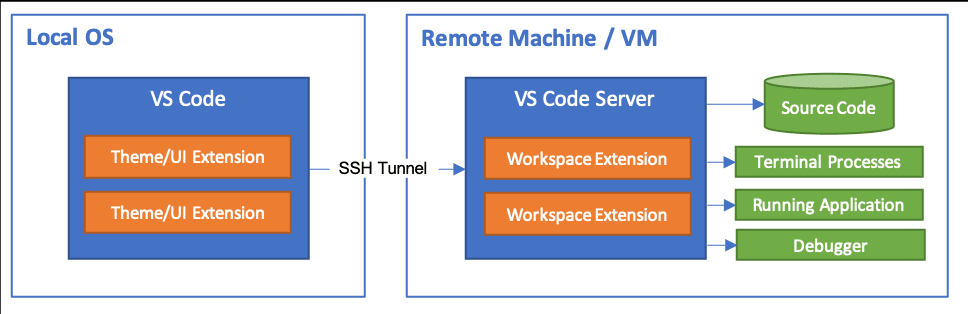

----------------------------------

<div>
  <img src=attachment:3be9a011-f19b-4b86-89d7-97979866374f.png title="Python Logo" width="320" style="float:right"/>
</div>

## Getting started
To successfully complete this tutorial, you must have finished these general steps before  
**as this tutorial is not an introduction to VSCode**:
* [x] Install VSCode on your local computer
    * [x] [Visual Studio Code (VSCode)](https://code.visualstudio.com/)
* [x] Install required VSCode extensions from within VSCode
    * [x] [Remote Development](https://marketplace.visualstudio.com/items?itemName=ms-vscode-remote.vscode-remote-extensionpack)
    * [x] [C/C++ extension](https://marketplace.visualstudio.com/items?itemName=ms-vscode.cpptools)
* [x] Test and use VSCode's UI

As soon as you are familiar with your local installation of VSCode in general we can proceed with enabling remote development.  
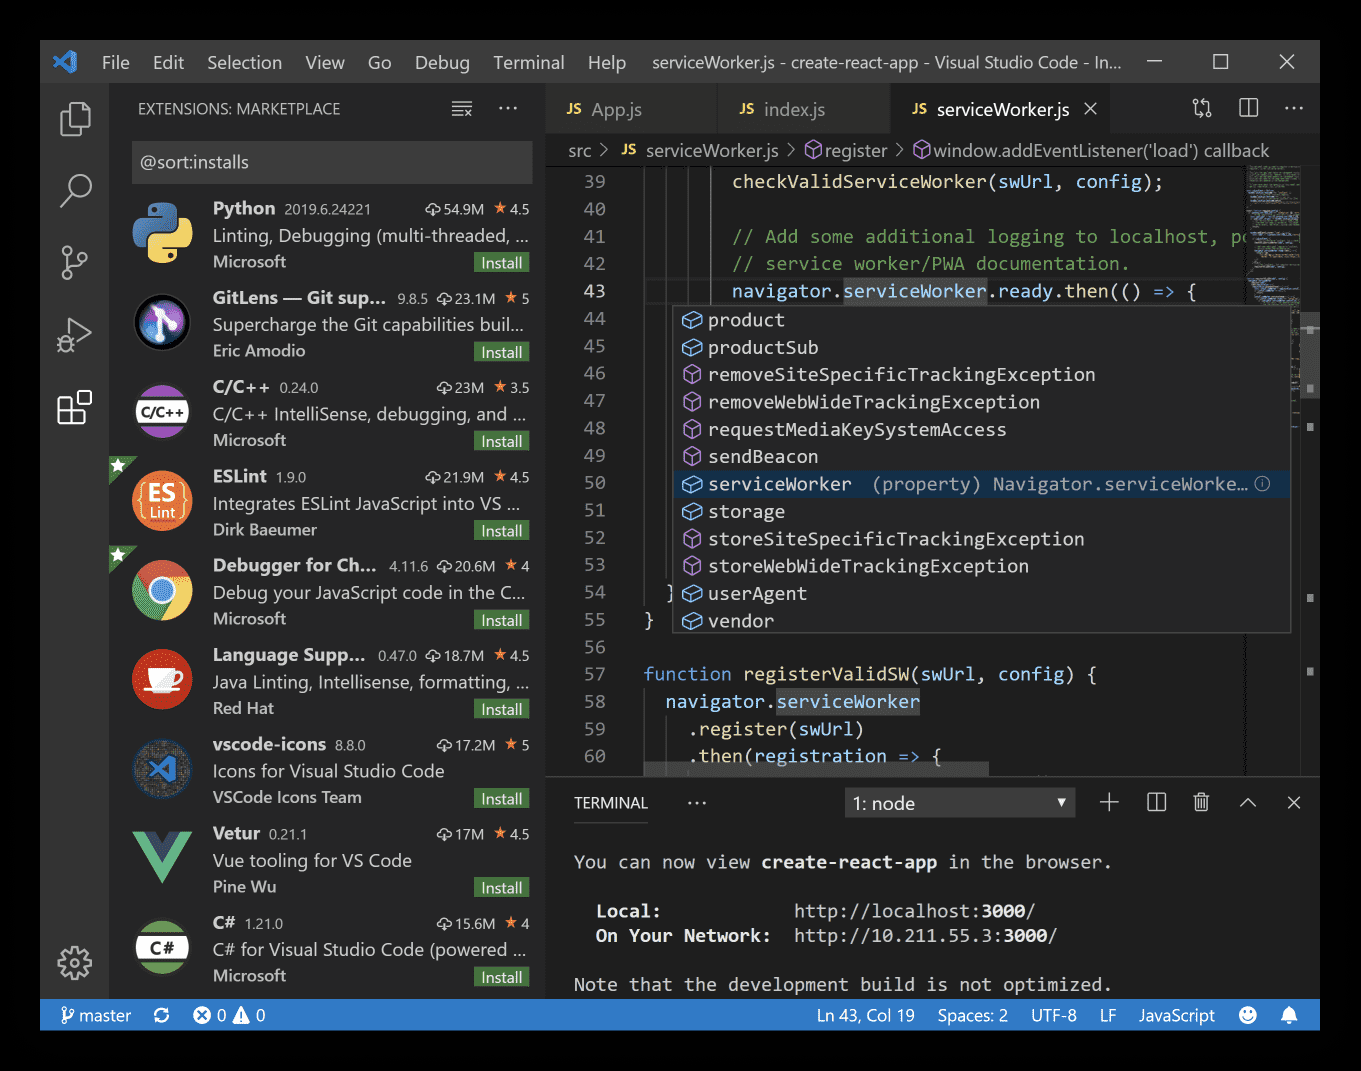

------------------------
## Prepare OpenSSH
First you need to have a proper installation and configuration of OpenSSH on your local computer as the Remote Development extension of VSCode will use it to connect to the remote systems.  
[more details](https://code.visualstudio.com/docs/remote/ssh)

#### 1) Install OpenSSH
You might already be able to login to a remote system via SSH, but please check if you are using OpenSSH and not some other tool like `PuTTY`.  
**ATTENTION: PuTTY is NOT supported!** but you can of course [convert your keys generated with PuTTygen](https://code.visualstudio.com/docs/remote/troubleshooting#_reusing-a-key-generated-in-puttygen)   

For this tutorial OpenSSH must be installed at least in version 7.3 (from 2016) for the required command `ProxyJump`.
  - Windows 10/11 using the [included OpenSSH Server](https://learn.microsoft.com/windows-server/administration/openssh/openssh_install_firstuse)
  - macOS 10.14+ (Mojave) SSH hosts with [Remote Login enabled](https://support.apple.com/guide/mac-help/allow-a-remote-computer-to-access-your-mac-mchlp1066/mac)  

#### 2) Create `.ssh` directory
OpenSSH is looking for key/config files by default in the following directory.  
Please ensure your keys/configs are stored here in the standard OpenSSH format: 
  - Windows: `C:\Users\<username>\.ssh\`
  - macOS/Linux: `~/.ssh`

#### 3) Upload SSH-keys
We assume you know how to create SSH-keypairs for the HPC systems, but one JSC specific detail has to be considered.  
<div class="alert alert-block alert-info">
<b>Important:</b></br>
When you upload your keys to [JuDoor](judoor.fz-juelich.de) the **From-clause** needs to be extended to be able to connect from an HPC login node to an HPC compute node later on.</br>  
Ensure you have added <b>10.0.0.0/8</b> to your From-clause!  
</div>
<div>
  <img src=attachment:16cb4627-ce78-4f37-8086-55eefa78618f.png title="Python Logo" width="800" style="left"/>
</div>

#### 4) Start your SSH-Agent
As we assume that you secure your SSH-keys with a passphrase it is important that you run an SSH-agent on your local system, which is known to OpenSSH.  
**ATTENTION: Pagent (from PuTTY) is NOT supported!**  
Ensure this SSH-agent is visible to VSCode later on. Best is to have it running as a service in the background.  
[more details](https://code.visualstudio.com/docs/remote/troubleshooting#_setting-up-the-ssh-agent)

#### 5) Create SSH configuration
Store the following with your usernames added in the file `config` in the created `.ssh` directory.
```
Host juwels
  HostName juwels.fz-juelich.de
  User <username on JUWELS>
  IdentityFile C:\Users\<username>\.ssh\id_ed_key
```

#### 6) Test OpenSSH installation
Test your OpenSSH in the with `ssh -vvv juwels` 
  - Windows: PowerShell
  - macOS/Linux: terminal
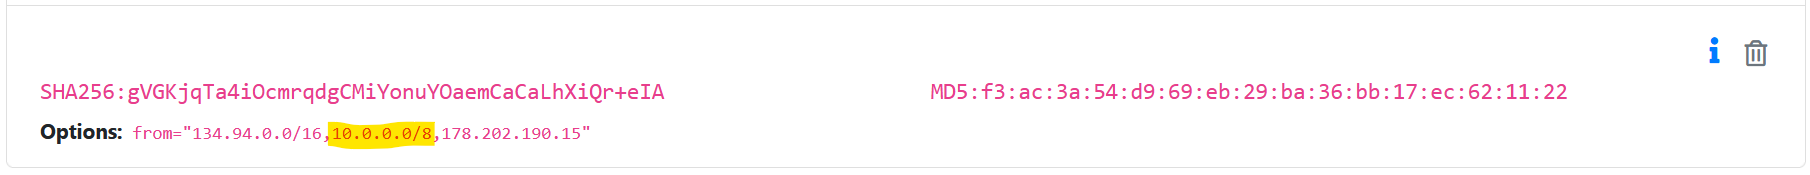

## Connect to HPC login nodes from VSCode

#### 1) Start VSCode and connect to the host `juwels`
The Remote SSH extensions adds a new icon to the left sidebar and reads the `config` file to show available systems.  
As you have added `juwels` already this will show up in the list.
<div>
  <img src=attachment:e25559b8-bfc1-4acc-a109-984f5f46ddde.png title="VSCode" width="800" style="right"/>
</div>

You need to specify the system you want to connect to as `Linux` and then enter the passphrase of your SSH key:
<div>
  <img src=attachment:f000366c-5fea-42df-a0aa-7fa080fd9100.png title="VSCode" width="800" style="right"/>
</div>

VSCode will now automatically install the `VSCode server` on the system in `$HOME/.vscode-server/`, start and connect to it.
<div>
  <img src=attachment:17f311e4-31ab-4a09-b8bf-0fa4fac1e577.png title="VSCode" width="800" style="right"/>
</div>

#### 2) Install extensions on remote host `juwels`
Your local extensions are not yet installed on the remote system, but you can simply do this now:
<div>
    <img src=attachment:f6be340d-ff50-44b1-9572-d5c860298c38.png title="VSCode" width="800" style="right"/>
</div>

#### 3) Test and use VSCode on the login nodes
Click for [more details](https://code.visualstudio.com/docs/cpp/config-linux) how to use VSCode with Linux.

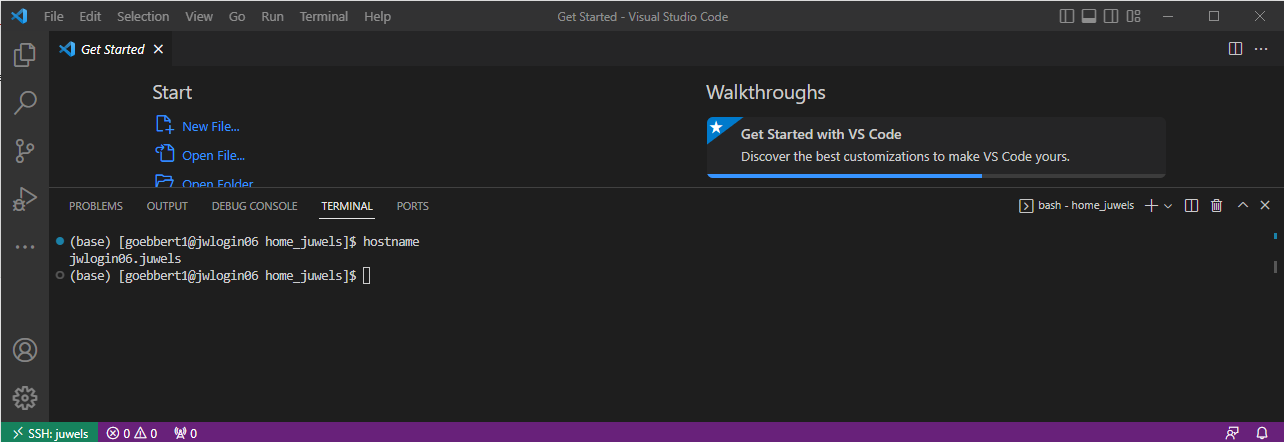
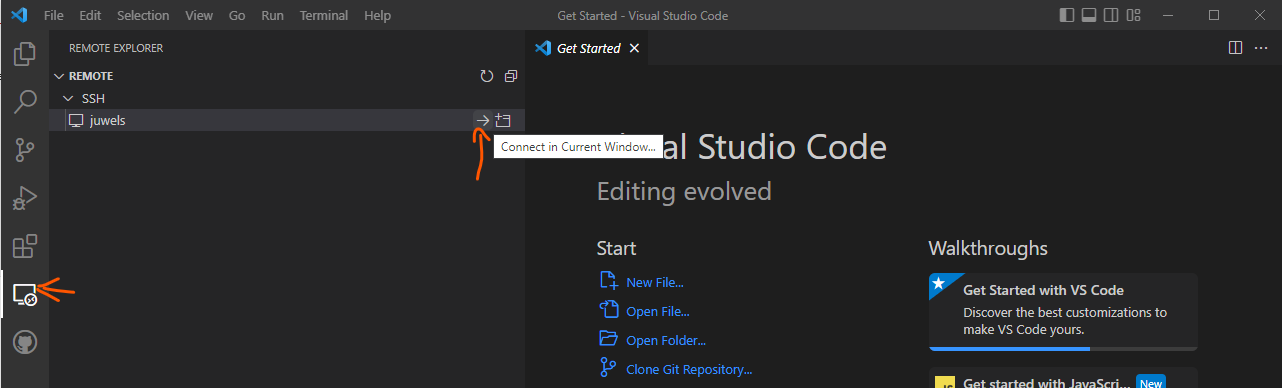
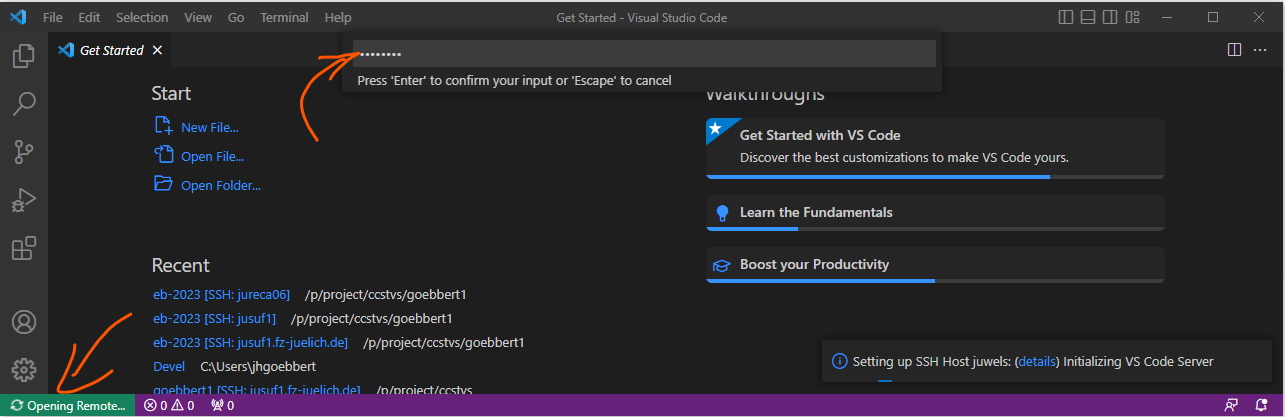
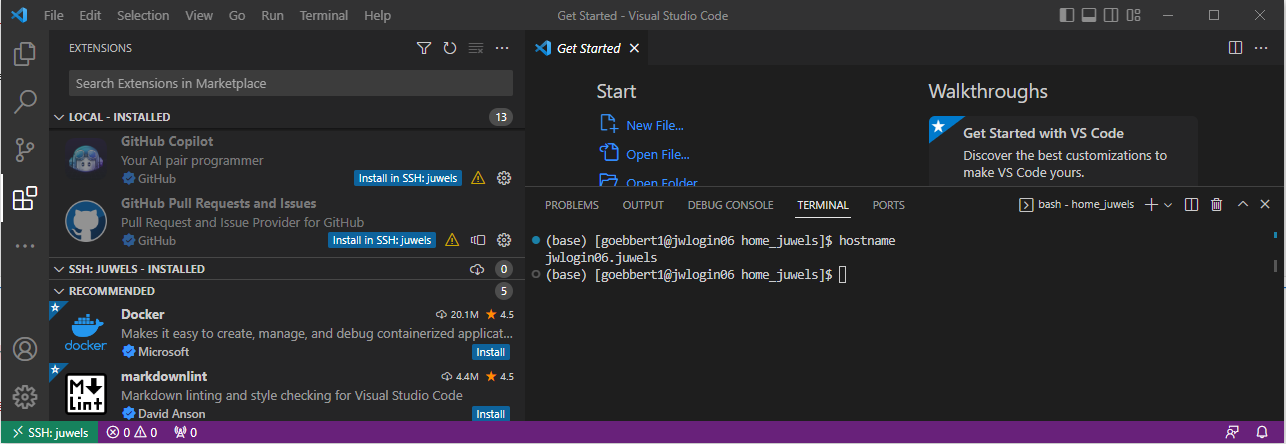

--------------------------

## Remote Development on the HPC compute nodes
To debug a running HPC process on compute nodes with VSCode we first need to connect to one of the SLURM-job's compute nodes itself.

#### 1) Prepare `config`
First we need to prepare our SSH `config` file.  
VSCode cannot connect to the compute nodes directly as they are not visible from your local computer.
But we can use the HPC login nodes as a gateway as they are part of the internal HPC network including the compute nodes.

This is done with the `ProxyJump` command.  
First we add the login nodes as jump hosts to the `config`:

```
# -- Jump Hosts == Login Nodes --
Host juwels_jump
    HostName juwels.fz-juelich.de
    User <username on JUWELS>
    IdentityFile C:\Users\<username>\.ssh\id_ed_juwels_key
Host jureca_jump
    HostName jureca.fz-juelich.de
    User <username on JURECA>
    IdentityFile C:\Users\<username>\.ssh\id_ed_jureca_key
Host jusuf_jump
    HostName jusuf.fz-juelich.de
    User <username on JUSUF>
    IdentityFile C:\Users\<username>\.ssh\id_ed_jusuf_key
Host hdfml_jump
    HostName hdfml.fz-juelich.de
    User <username on HDFML>
    IdentityFile C:\Users\<username>\.ssh\id_ed_hdfml_key
```
Ensure you replace the place holders with your username and your private key file path.

In the second step we add configurations for hosts with special name patterns.
```
# -- Compute Nodes --
Host *.juwels
    User <username on JUWELS>
    StrictHostKeyChecking no
    IdentityFile C:\Users\<username>\.ssh\id_ed_juwels_key
    ProxyJump juwels_jump
Host *.jureca
    User <username on JUWELS>
    StrictHostKeyChecking no
    IdentityFile C:\Users\<username>\.ssh\id_ed_jureca_key
    ProxyJump jureca_jump
Host *.jusuf
    User <username on JUWELS>
    StrictHostKeyChecking no
    IdentityFile C:\Users\<username>\.ssh\id_ed_jusuf_key
    ProxyJump jusuf_jump
Host *.hdfml
    User <username on JUWELS>
    StrictHostKeyChecking no
    IdentityFile C:\Users\<username>\.ssh\id_ed_hdfml_key
    ProxyJump hdfml_jump
```
We better disable StrictHostKeyChecking as this can be different for each of the hundreds of compute nodes.  
The private key for the login on the jump hosts (login nodes) as well as the login on the compute nodes (*.juwels, etc.) remains on your local computer.  

<div class="alert alert-block alert-info">
<b>By-the-way:</b></br>
ProxyJump has great security benefits and could be a good alternative to a ForwardAgent:</br>  
https://www.infoworld.com/article/3619278/proxyjump-is-safer-than-ssh-agent-forwarding.html
</div>

#### 2) Test OpenSSH ProxyJump
Test the new OpenSSH configuration with `ssh -vvv jwlogin04i.juwels` 
  - Windows: PowerShell
  - macOS/Linux: terminal

<div class="alert alert-block alert-danger">
<b>Important:</b></br>
HPC systems have in general multiple network interfaces (e.g. ethernet for administration, Infiniband for high bandwidth).</br>
At JSC hostnames can be extended by an <b>i</b> to access the high-bandwidth interface Infiniband.</br>
Ensure you <b>ALWAYS</b> extend the hostname with this <b>i</b>.
</div>

Let's have a look at the output of this command.  
1) We can read that `config` is used to read the options for a `*.juwels` host.  
```
[..]
debug1: Reading configuration data C:\\Users\\jhgoebbert/.ssh/config
debug1: C:\\Users\\jhgoebbert/.ssh/config line 56: Applying options for *.juwels
[..]
debug1: Setting implicit ProxyCommand from ProxyJump: "C:\\Windows\\System32\\OpenSSH\\ssh.exe"  -vvv -W "[%h]:%p" juwels_jump
debug1: Executing proxy command: exec "C:\\Windows\\System32\\OpenSSH\\ssh.exe"  -vvv -W "[jwlogin04i.juwels]:22" juwels_jump
[..]
```

2) ... and than applys the options for our jump host:
```
debug1: Reading configuration data C:\\Users\\jhgoebbert/.ssh/config
debug1: C:\\Users\\jhgoebbert/.ssh/config line 38: Applying options for juwels_jump
[..]
```

3) SSH connects first to the jump host:
```
debug2: resolving "juwels.fz-juelich.de" port 22
debug2: ssh_connect_direct
debug1: Connecting to juwels_jump [134.94.0.104] port 22.
debug1: Connection established.
[..]
debug1: Authenticating to juwels.fz-juelich.de:22 as 'goebbert1'
[..]
debug1: Host 'juwels.fz-juelich.de' is known and matches the ECDSA host key.
debug1: Found key in C:\\Users\\jhgoebbert/.ssh/known_hosts:16
[..]
debug1: Will attempt key: goebbert1@juwels ED25519 SHA256:3h0t3loQgAeVh2rlBnyKccDDWgf9xk2GwYdpU9lA1a8 agent
debug1: Will attempt key: C:\\Users\\jhgoebbert\\.ssh\\id_ed_goebbert1@juwels.prv  explicit
[..]
debug1: Authentication succeeded (publickey).
Authenticated to juwels.fz-juelich.de ([134.94.0.104]:22).
```

4) ... and then connects to the target node: 
```
debug3: ssh_init_stdio_forwarding: jwlogin04i.juwels:22
debug1: channel_connect_stdio_fwd jwlogin04i.juwels:22
[..]
debug1: Authenticating to jwlogin04i.juwels:22 as 'goebbert1'
[..]
debug1: Host 'jwlogin04i.juwels' is known and matches the ECDSA host key.
debug1: Found key in C:\\Users\\jhgoebbert/.ssh/known_hosts:22
[..]
debug1: Will attempt key: goebbert1@juwels ED25519 SHA256:3h0t3loQgAeVh2rlBnyKccDDWgf9xk2GwYdpU9lA1a8 agent
debug1: Will attempt key: C:\\Users\\jhgoebbert\\.ssh\\id_ed_goebbert1@juwels.prv  explicit
[..]
Authenticated to jwlogin04i.juwels (via proxy).
[..]
```

Wir sollten jetzt mit dem Rechner `jwlogin04` im Terminal verbunden sein.

## Connect to HPC login compute nodes from VSCode
We assume you know how to start a SLURM job on any of the JSC's HPC systems.  
If this is not the case than this tutorial is not yours.

<b>Important:</b></br>
You can only SSH to compute nodes which are currently running a SLURM job of yours.</br>
</div>

#### 1) Start your SLURM job on the HPC system
Start your SLURM job from the terminal (e.g. `sbatch mysim.job`).  
First the job will be pending
```
[jwlogin04 ~]$ squeue -u $USER
             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
           6462769     batch  example goebbert PD       0:00      1 (Priority)
```
As soon as the job is running you can check which compute node it was scheduled to:
```
[jwlogin04 ~]$ squeue -u $USER
           JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
           6462769     batch  example goebbert  R       4:31      1 jwc00n051
```
In this example we are running a 1-node-job which on `jwc00n051`  
The long hostname is `jwc00n051.juwels` as it runs on JUWELS.


#### 1) Start VSCode and connect to the host `jwc00n051i.juwels`
Connecting to `jwc00n051i.juwels` is simple. We just follow the instructions from above with the only difference in the hostname.

VSCode will now automatically install the `VSCode server` on the system in `$HOME/.vscode-server/`.  
It will figure out that we have no internet on the compute nodes and will copy the installation files with `scp` in the background from your local computer.

#### 2) Install extensions on remote host `juwels`
Your local extensions are not yet installed on the remote system, but you can simply do this now:

#### 3) Test and use VSCode on the login nodes
Click for [more details](https://code.visualstudio.com/docs/cpp/config-linux) how to use VSCode with Linux.
